## Import packages /data

In [21]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier

In [22]:
try:
    import shap
    SHAP_AVAILABLE = True
except ImportError:
    SHAP_AVAILABLE = False

In [23]:
df = pd.read_csv('../Data/digital_marketing_campaign_dataset.csv')

## EDA & Data Cleaning

In [24]:
df.head(10)

,CustomerID,Age,Gender,Income,CampaignChannel,CampaignType,AdSpend,ClickThroughRate,ConversionRate,WebsiteVisits,PagesPerVisit,TimeOnSite,SocialShares,EmailOpens,EmailClicks,PreviousPurchases,LoyaltyPoints,AdvertisingPlatform,AdvertisingTool,Conversion
0,8000,56,Female,136912,Social Media,Awareness,6497.870068,0.043919,0.088031,0,2.399017,7.396803,19,6,9,4,688,IsConfid,ToolConfid,1
1,8001,69,Male,41760,Email,Retention,3898.668606,0.155725,0.182725,42,2.917138,5.352549,5,2,7,2,3459,IsConfid,ToolConfid,1
2,8002,46,Female,88456,PPC,Awareness,1546.429596,0.277490,0.076423,2,8.223619,13.794901,0,11,2,8,2337,IsConfid,ToolConfid,1
3,8003,32,Female,44085,PPC,Conversion,539.525936,0.137611,0.088004,47,4.540939,14.688363,89,2,2,0,2463,IsConfid,ToolConfid,1
4,8004,60,Female,83964,PPC,Conversion,1678.043573,0.252851,0.109940,0,2.046847,13.993370,6,6,6,8,4345,IsConfid,ToolConfid,1
5,8005,25,Female,42925,Social Media,Awareness,9579.388247,0.153795,0.161316,6,2.125850,7.752831,95,5,8,0,3316,IsConfid,ToolConfid,1
6,8006,38,Female,25615,Referral,Awareness,7302.899852,0.040975,0.060977,42,1.753995,10.698672,54,14,3,6,930,IsConfid,ToolConfid,1
7,8007,56,Female,57083,Social Media,Conversion,5324.283667,0.052878,0.188946,48,2.626015,2.987817,96,9,3,0,2983,IsConfid,ToolConfid,1
8,8008,36,Female,140788,Email,Retention,9421.250951,0.023536,0.112585,13,5.472843,14.287421,73,4,8,5,460,IsConfid,ToolConfid,1
9,8009,40,Male,130764,Social Media,Awareness,6229.193333,0.066641,0.169786,22,1.135665,4.613312,14,8,4,8,3789,IsConfid,ToolConfid,1


In [25]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8000 entries, 0 to 7999
Data columns (total 20 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   CustomerID           8000 non-null   int64  
 1   Age                  8000 non-null   int64  
 2   Gender               8000 non-null   object 
 3   Income               8000 non-null   int64  
 4   CampaignChannel      8000 non-null   object 
 5   CampaignType         8000 non-null   object 
 6   AdSpend              8000 non-null   float64
 7   ClickThroughRate     8000 non-null   float64
 8   ConversionRate       8000 non-null   float64
 9   WebsiteVisits        8000 non-null   int64  
 10  PagesPerVisit        8000 non-null   float64
 11  TimeOnSite           8000 non-null   float64
 12  SocialShares         8000 non-null   int64  
 13  EmailOpens           8000 non-null   int64  
 14  EmailClicks          8000 non-null   int64  
 15  PreviousPurchases    8000 non-null   i

In [26]:
df.isnull().sum()

CustomerID             0
Age                    0
Gender                 0
Income                 0
CampaignChannel        0
CampaignType           0
AdSpend                0
ClickThroughRate       0
ConversionRate         0
WebsiteVisits          0
PagesPerVisit          0
TimeOnSite             0
SocialShares           0
EmailOpens             0
EmailClicks            0
PreviousPurchases      0
LoyaltyPoints          0
AdvertisingPlatform    0
AdvertisingTool        0
Conversion             0
dtype: int64

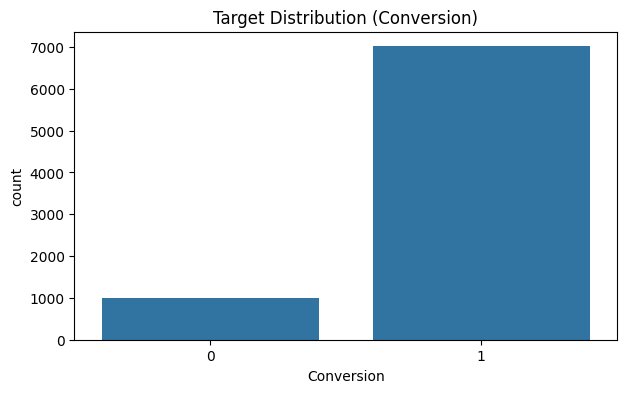

In [27]:
# Plot distribution of target
plt.figure(figsize=(7, 4))
sns.countplot(data=df, x="Conversion")
plt.title("Target Distribution (Conversion)")
plt.show()

<Figure size 1000x600 with 0 Axes>

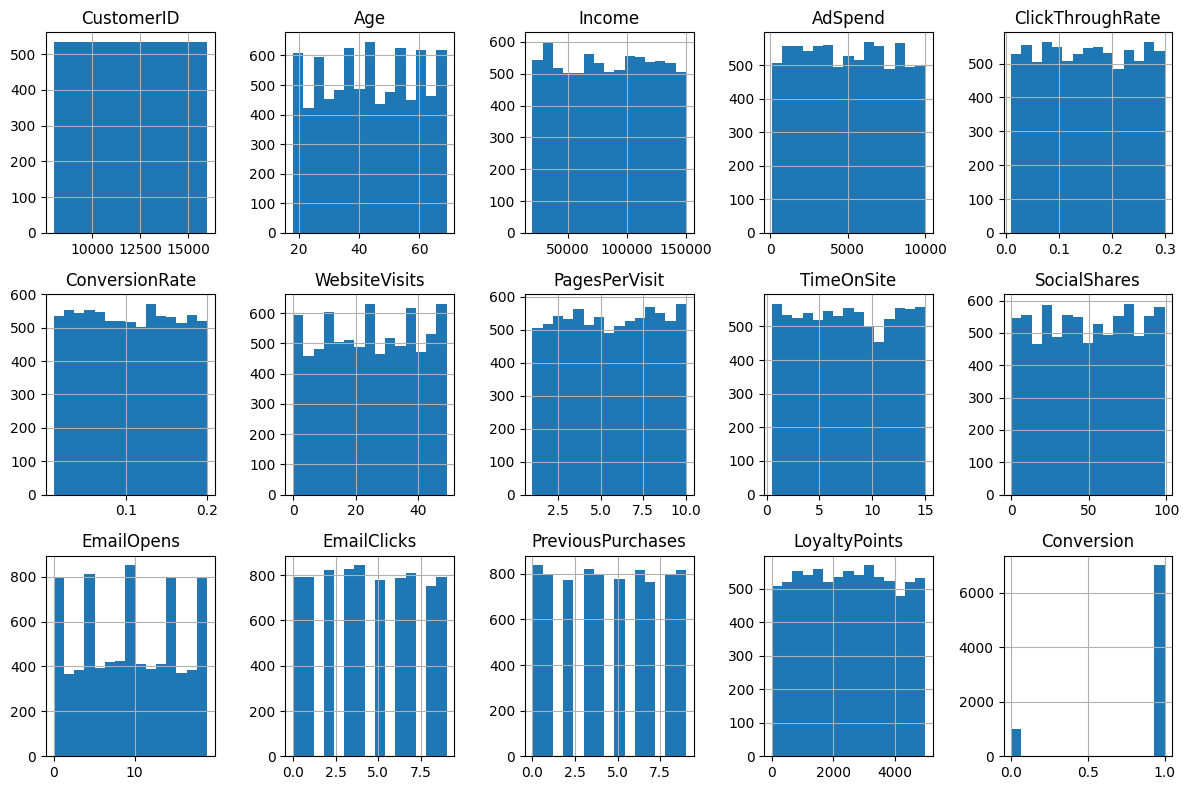

In [28]:
# Distributions of numeric columns
numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
plt.figure(figsize=(10, 6))
df[numeric_cols].hist(figsize=(12, 8), bins=15, layout=(3, 5))
plt.tight_layout()
plt.show()

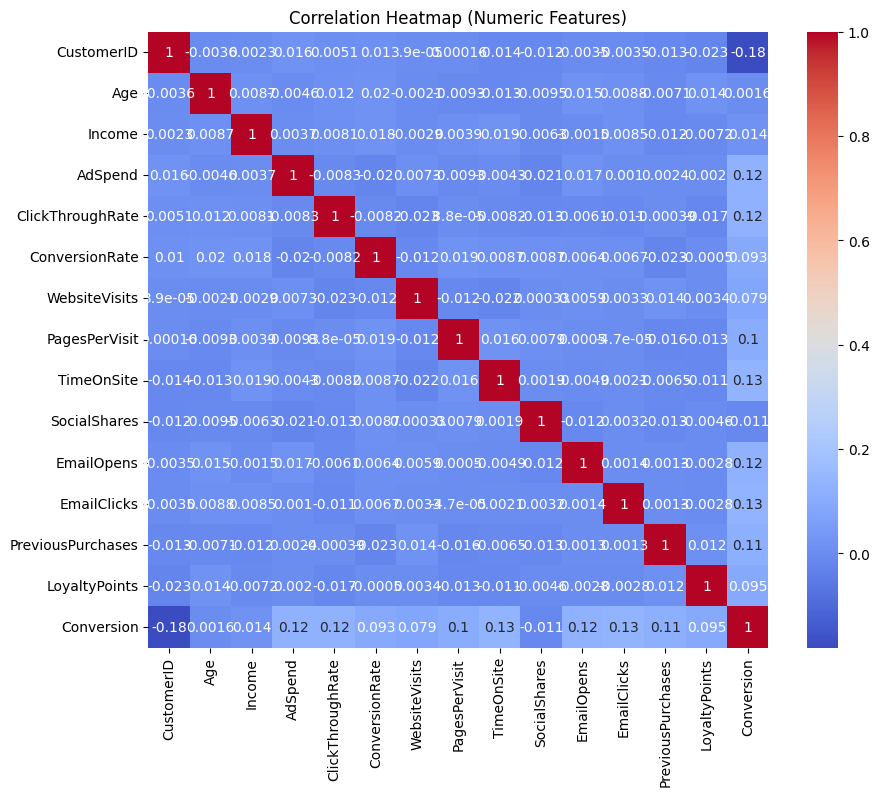

In [29]:
# Correlation heatmap for numeric features
plt.figure(figsize=(10, 8))
sns.heatmap(df[numeric_cols].corr(), annot=True, cmap="coolwarm")
plt.title("Correlation Heatmap (Numeric Features)")
plt.show()

In [30]:
# Drop ID column
df.drop(columns=["CustomerID"], inplace=True)

## Feature Engineering

In [31]:
TARGET = "Conversion"
X = df.drop(columns=[TARGET])
y = df[TARGET]

In [32]:
# Identify categorical vs numeric
cat_cols = X.select_dtypes(include=["object"]).columns.tolist()
num_cols = X.select_dtypes(include=[np.number]).columns.tolist()

### Preprocessing Pipelines(Encode Categorical Features & Standardization)

- Models that require standardization:

    Logistic Regression

    SVM

- Models that don’t require standardization:
    
    Random Forest
    
    Gradient Boosting
    
    XGBoost

In [33]:
preprocessor_linear = ColumnTransformer([
    ("num", StandardScaler(), num_cols),
    ("cat", OneHotEncoder(drop="first", handle_unknown="ignore"), cat_cols)
])

preprocessor_tree = ColumnTransformer([
    ("num", "passthrough", num_cols),
    ("cat", OneHotEncoder(drop="first", handle_unknown="ignore"), cat_cols)
])

## Splitting Train/Test Data

In [34]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

### Model Selection

In [35]:
models_linear = {
    "LogisticRegression": LogisticRegression(max_iter=1000, class_weight="balanced"),
    "SVM": SVC(probability=True, class_weight="balanced")  # Keep probability=True for ROC-AUC
}

models_tree = {
    "RandomForest": RandomForestClassifier(random_state=42),
    "GradientBoosting": GradientBoostingClassifier(random_state=42),
    "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric="logloss", random_state=42)
}

### Grid search parameters for each model

In [36]:
param_grid = {
    "LogisticRegression": {
        "classifier__C": [0.01, 0.1, 1.0]
    },
    "SVM": {
        "classifier__C": [0.1, 1.0],
        "classifier__kernel": ["linear", "rbf"]
    },
    "RandomForest": {
        "classifier__n_estimators": [100, 200],
        "classifier__max_depth": [3, 5]
    },
    "GradientBoosting": {
        "classifier__n_estimators": [100, 200],
        "classifier__learning_rate": [0.05, 0.1],
        "classifier__max_depth": [3, 5]
    },
    "XGBoost": {
        "classifier__n_estimators": [100, 200],
        "classifier__learning_rate": [0.05, 0.1],
        "classifier__max_depth": [3, 5]
    }
}

In [37]:
# Training and Evaluation
best_estimators = {}
results = {}

def train_and_evaluate(model_dict, preprocessor):
    for name, model in model_dict.items():
        print(f"\n===== Training {name} =====")
        pipe = Pipeline([
            ("preprocessor", preprocessor),
            ("classifier", model)
        ])

        gs = GridSearchCV(pipe, param_grid[name], scoring="roc_auc", cv=3, verbose=1)
        gs.fit(X_train, y_train)
        best_model = gs.best_estimator_
        best_estimators[name] = best_model

        y_pred = best_model.predict(X_test)
        y_prob = best_model.predict_proba(X_test)[:, 1]

        acc = accuracy_score(y_test, y_pred)
        auc = roc_auc_score(y_test, y_prob)
        cm = confusion_matrix(y_test, y_pred)
        cr = classification_report(y_test, y_pred)

        print(f"Best Params: {gs.best_params_}")
        print(f"Accuracy: {acc:.4f}, ROC-AUC: {auc:.4f}")
        print("Confusion Matrix:\n", cm)
        print("Classification Report:\n", cr)

        results[name] = {
            "Accuracy": acc,
            "ROC-AUC": auc,
            "ConfusionMatrix": cm,
            "ClassificationReport": cr
        }

        # Confusion Matrix Plot
        plt.figure(figsize=(4, 3))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
        plt.title(f"{name} - Confusion Matrix")
        plt.xlabel("Predicted")
        plt.ylabel("Actual")
        plt.tight_layout()
        plt.show()



===== Training LogisticRegression =====
Fitting 3 folds for each of 3 candidates, totalling 9 fits
Best Params: {'classifier__C': 0.01}
Accuracy: 0.7531, ROC-AUC: 0.7790
Confusion Matrix:
 [[ 145   53]
 [ 342 1060]]
Classification Report:
               precision    recall  f1-score   support

           0       0.30      0.73      0.42       198
           1       0.95      0.76      0.84      1402

    accuracy                           0.75      1600
   macro avg       0.63      0.74      0.63      1600
weighted avg       0.87      0.75      0.79      1600



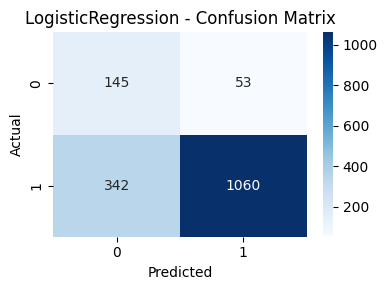


===== Training SVM =====
Fitting 3 folds for each of 4 candidates, totalling 12 fits
Best Params: {'classifier__C': 0.1, 'classifier__kernel': 'rbf'}
Accuracy: 0.8100, ROC-AUC: 0.8008
Confusion Matrix:
 [[ 136   62]
 [ 242 1160]]
Classification Report:
               precision    recall  f1-score   support

           0       0.36      0.69      0.47       198
           1       0.95      0.83      0.88      1402

    accuracy                           0.81      1600
   macro avg       0.65      0.76      0.68      1600
weighted avg       0.88      0.81      0.83      1600



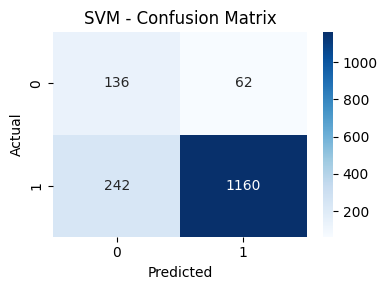


===== Training RandomForest =====
Fitting 3 folds for each of 4 candidates, totalling 12 fits
Best Params: {'classifier__max_depth': 5, 'classifier__n_estimators': 200}
Accuracy: 0.8775, ROC-AUC: 0.8125
Confusion Matrix:
 [[   3  195]
 [   1 1401]]
Classification Report:
               precision    recall  f1-score   support

           0       0.75      0.02      0.03       198
           1       0.88      1.00      0.93      1402

    accuracy                           0.88      1600
   macro avg       0.81      0.51      0.48      1600
weighted avg       0.86      0.88      0.82      1600



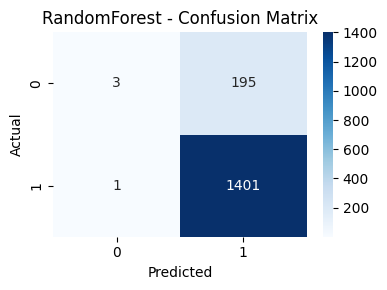


===== Training GradientBoosting =====
Fitting 3 folds for each of 8 candidates, totalling 24 fits
Best Params: {'classifier__learning_rate': 0.1, 'classifier__max_depth': 3, 'classifier__n_estimators': 100}
Accuracy: 0.9100, ROC-AUC: 0.8168
Confusion Matrix:
 [[  66  132]
 [  12 1390]]
Classification Report:
               precision    recall  f1-score   support

           0       0.85      0.33      0.48       198
           1       0.91      0.99      0.95      1402

    accuracy                           0.91      1600
   macro avg       0.88      0.66      0.71      1600
weighted avg       0.90      0.91      0.89      1600



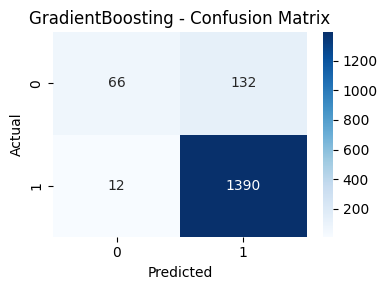


===== Training XGBoost =====
Fitting 3 folds for each of 8 candidates, totalling 24 fits


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [15:56:10] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [15:56:10] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [15:56:10] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [15:56:10] WARN

Best Params: {'classifier__learning_rate': 0.05, 'classifier__max_depth': 3, 'classifier__n_estimators': 200}
Accuracy: 0.9150, ROC-AUC: 0.8212
Confusion Matrix:
 [[  69  129]
 [   7 1395]]
Classification Report:
               precision    recall  f1-score   support

           0       0.91      0.35      0.50       198
           1       0.92      1.00      0.95      1402

    accuracy                           0.92      1600
   macro avg       0.91      0.67      0.73      1600
weighted avg       0.91      0.92      0.90      1600



/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [15:56:12] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


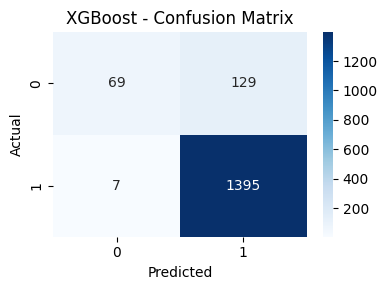

In [38]:
# Train both model groups
train_and_evaluate(models_linear, preprocessor_linear)
train_and_evaluate(models_tree, preprocessor_tree)

In [39]:
# Compare results
print("\n===== MODEL COMPARISON =====")
for model, metrics in results.items():
    print(f"{model}: Accuracy={metrics['Accuracy']:.4f}, ROC-AUC={metrics['ROC-AUC']:.4f}")



===== MODEL COMPARISON =====
LogisticRegression: Accuracy=0.7531, ROC-AUC=0.7790
SVM: Accuracy=0.8100, ROC-AUC=0.8008
RandomForest: Accuracy=0.8775, ROC-AUC=0.8125
GradientBoosting: Accuracy=0.9100, ROC-AUC=0.8168
XGBoost: Accuracy=0.9150, ROC-AUC=0.8212


XGBoost and Gradient Boosting achieved the highest accuracy and ROC-AUC, making them the strongest performers in predicting customer conversion.

Linear models (Logistic Regression and SVM) had moderate performance and captured some key patterns but struggled with class imbalance (lower precision/recall for the minority class).

### Confusion Matrix Observations
Tree-based models (especially XGBoost) showed strong recall on the majority class and modest improvement on the minority class (class 0).

Logistic Regression shows higher recall on class 0 compared to Random Forest but with a tradeoff in precision.

SVM balanced both classes better than Logistic Regression but still missed some class 0 cases.



/var/folders/jd/8j3jmbks4nvghd_f754z9gzm0000gn/T/ipykernel_31437/2165348908.py:22: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=imp_df, x="Coefficient", y="Feature", palette="coolwarm")



LogisticRegression Feature Importance (based on coefficients):
                    Feature  Coefficient
19  CampaignType_Conversion     0.447166
3          ClickThroughRate     0.407485
7                TimeOnSite     0.396110
10              EmailClicks     0.376220
2                   AdSpend     0.348063
9                EmailOpens     0.341013
11        PreviousPurchases     0.328539
12            LoyaltyPoints     0.324635
6             PagesPerVisit     0.268807
4            ConversionRate     0.243616


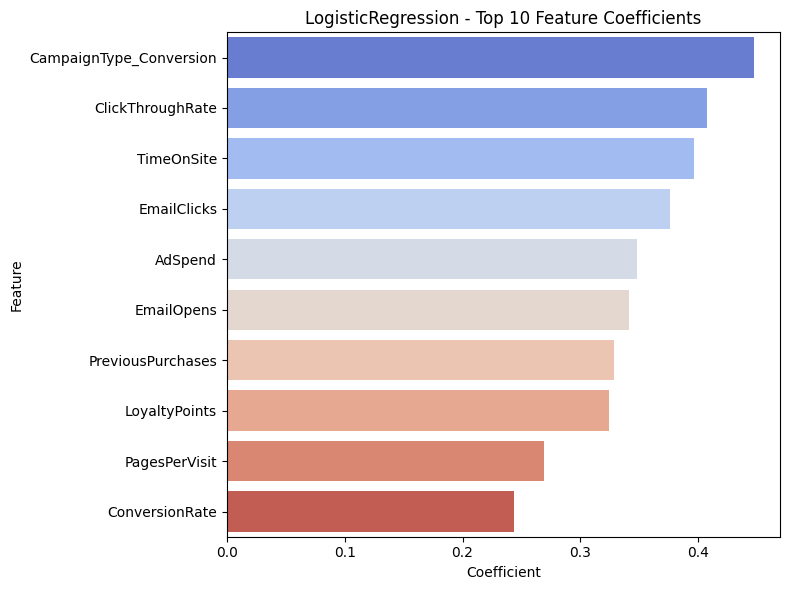


SVM Feature Importance (based on coefficients):


In [40]:
for name in ["LogisticRegression", "SVM"]:
    if name in best_estimators:
        print(f"\n{name} Feature Importance (based on coefficients):")
        clf = best_estimators[name].named_steps["classifier"]
        preprocessor = best_estimators[name].named_steps["preprocessor"]

        feat_names_num = preprocessor.named_transformers_["num"].get_feature_names_out(num_cols)
        feat_names_cat = preprocessor.named_transformers_["cat"].get_feature_names_out(cat_cols)
        all_feat_names = np.concatenate((feat_names_num, feat_names_cat))

        if hasattr(clf, "coef_"):
            coefs = clf.coef_[0]
            imp_df = pd.DataFrame({
                "Feature": all_feat_names,
                "Coefficient": coefs,
                "AbsCoef": np.abs(coefs)
            }).sort_values("AbsCoef", ascending=False).head(10)

            print(imp_df[["Feature", "Coefficient"]])

            plt.figure(figsize=(8, 6))
            sns.barplot(data=imp_df, x="Coefficient", y="Feature", palette="coolwarm")
            plt.title(f"{name} - Top 10 Feature Coefficients")
            plt.tight_layout()
            plt.show()



===== FEATURE IMPORTANCE FOR TREE-BASED MODELS =====

RandomForest Top 10 Features:
1. PagesPerVisit: 0.1277
2. PreviousPurchases: 0.1158
3. ClickThroughRate: 0.1063
4. TimeOnSite: 0.1036
5. AdSpend: 0.0953
6. ConversionRate: 0.0842
7. EmailClicks: 0.0811
8. LoyaltyPoints: 0.0803
9. EmailOpens: 0.0718
10. WebsiteVisits: 0.0575


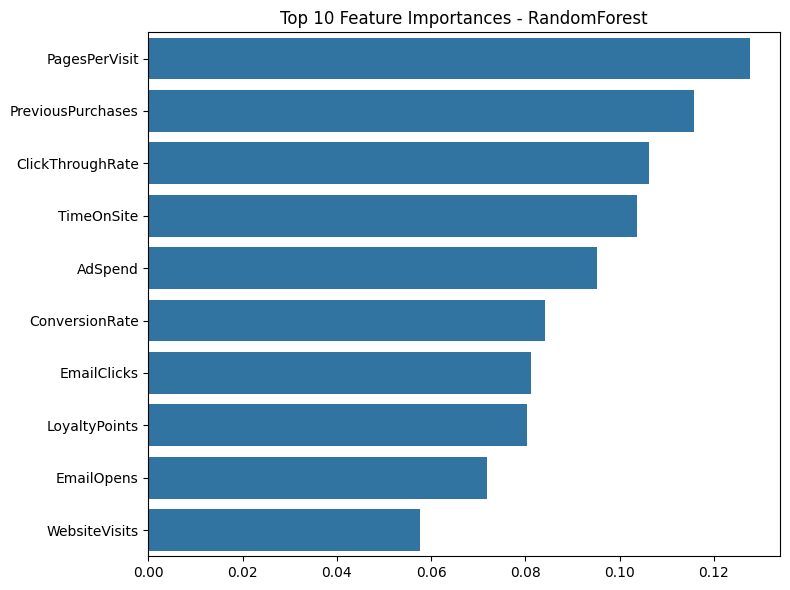


GradientBoosting Top 10 Features:
1. AdSpend: 0.1302
2. TimeOnSite: 0.1231
3. PagesPerVisit: 0.1129
4. ClickThroughRate: 0.1089
5. PreviousPurchases: 0.0974
6. ConversionRate: 0.0932
7. LoyaltyPoints: 0.0789
8. EmailOpens: 0.0730
9. EmailClicks: 0.0727
10. WebsiteVisits: 0.0534


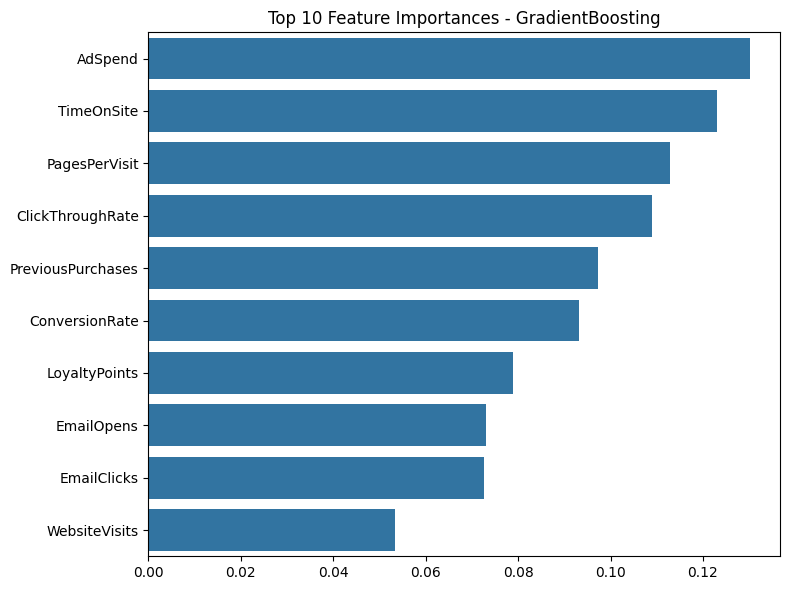


XGBoost Top 10 Features:
1. PreviousPurchases: 0.1207
2. EmailClicks: 0.0992
3. PagesPerVisit: 0.0804
4. TimeOnSite: 0.0753
5. ConversionRate: 0.0723
6. AdSpend: 0.0718
7. EmailOpens: 0.0716
8. CampaignType_Conversion: 0.0704
9. ClickThroughRate: 0.0658
10. WebsiteVisits: 0.0656


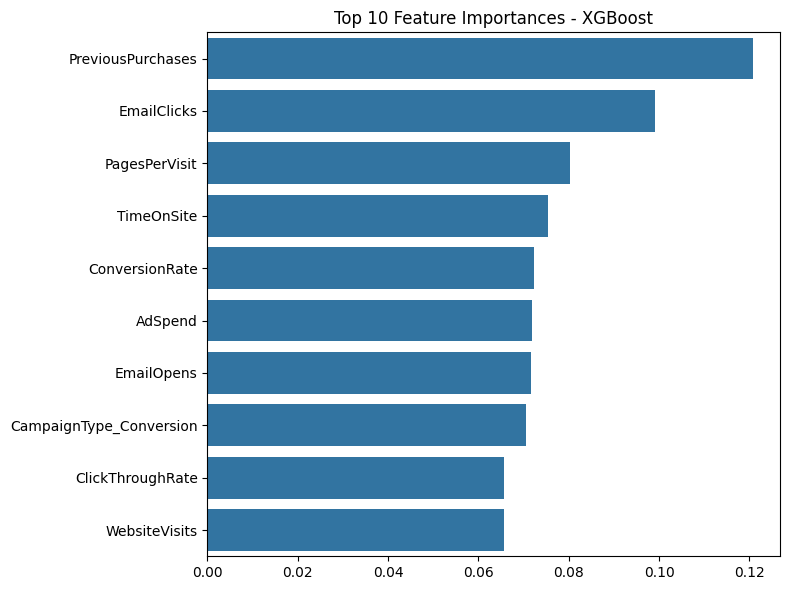

In [41]:
print("\n===== FEATURE IMPORTANCE FOR TREE-BASED MODELS =====")
tree_models = ["RandomForest", "GradientBoosting", "XGBoost"]

for tm in tree_models:
    if tm in best_estimators:
        clf = best_estimators[tm].named_steps["classifier"]
        preprocessor = best_estimators[tm].named_steps["preprocessor"]
        
        if hasattr(clf, "feature_importances_"):
            feat_names_num = preprocessor.named_transformers_["num"].get_feature_names_out(num_cols)
            feat_names_cat = preprocessor.named_transformers_["cat"].get_feature_names_out(cat_cols)
            all_feat_names = np.concatenate((feat_names_num, feat_names_cat))

            importances = clf.feature_importances_
            sorted_idx = np.argsort(importances)[::-1]
            top_n = 10
            print(f"\n{tm} Top {top_n} Features:")
            for i in range(top_n):
                print(f"{i+1}. {all_feat_names[sorted_idx[i]]}: {importances[sorted_idx[i]]:.4f}")

            plt.figure(figsize=(8, 6))
            sns.barplot(x=importances[sorted_idx[:top_n]],
                        y=all_feat_names[sorted_idx[:top_n]])
            plt.title(f"Top {top_n} Feature Importances - {tm}")
            plt.tight_layout()
            plt.show()

        if SHAP_AVAILABLE:
            print(f"\nRunning SHAP for {tm} (first 300 rows)...")
            X_sample = X_train[:300]
            y_sample = y_train[:300]
            X_transformed = preprocessor.transform(X_sample)

            explainer = shap.TreeExplainer(clf)
            shap_values = explainer.shap_values(X_transformed)
            shap.summary_plot(shap_values, X_transformed,
                              feature_names=all_feat_names, show=True)



### Top Feature Importance Across Models
Linear Models (Coefficients)
CampaignType_Conversion, ClickThroughRate, and TimeOnSite have the highest positive coefficients in Logistic Regression.

Signs of coefficients are interpretable:

    - Positive coefficients indicate that higher values of the feature increase conversion probability.

    - CampaignType_Conversion with the highest positive weight suggests this type of campaign is highly effective.

Tree-Based Models (Gini Gain / SHAP)
PagesPerVisit, TimeOnSite, and ClickThroughRate are consistently in the top 5 across all tree-based models.

EmailClicks and EmailOpens rank high in XGBoost, emphasizing the impact of email campaign interactions.

PreviousPurchases and LoyaltyPoints show up across models, suggesting historical loyalty contributes to new conversions.
